# I'm not positive but I'm not sure anything in this notebook is actually necessary - might actually be a dead end.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import astropy.io.fits as fits
import glob
import os
from lsst.sims.photUtils import Sed, Bandpass

In [2]:
# Loading model spectra library:

with np.load('model_atm_mags.npz') as nump_zip:    
    model_atm_mags = nump_zip['model_atm_mags']    
print(model_atm_mags[0:5]) # checking it loaded properly, not strictly necessary

[(4500., -0.5,  0., -36.75917312, -36.67754745, -36.60231896, -36.46183078, -35.98928243, -35.62842945, -35.07766659, -33.39341888, -36.26345551, -37.28278396, -37.60873741, -37.75330019, -37.88343834)
 (4500., -0.5,  5., -36.75301122, -36.67112279, -36.59598614, -36.45810154, -35.99674578, -35.62237873, -35.07420168, -33.63059939, -36.31710071, -37.27968823, -37.59212496, -37.73715901, -37.86365331)
 (4500., -0.5, 10., -36.74791317, -36.66573983, -36.59083363, -36.45545727, -36.00553415, -35.61797843, -35.07157242, -33.83040458, -36.3517548 , -37.27365921, -37.57955099, -37.72551358, -37.84955013)
 (4500., -0.5, 15., -36.74368777, -36.66139315, -36.58641668, -36.45372825, -36.0151221 , -35.6146966 , -35.06933524, -33.9908113 , -36.37246746, -37.26639577, -37.57026928, -37.71722283, -37.83971741)
 (4500., -0.5, 20., -36.74016048, -36.65764538, -36.58281673, -36.45253086, -36.02414216, -35.61213708, -35.06727088, -34.11703309, -36.38368347, -37.25922626, -37.56362239, -37.71132166, -37.

In [3]:
plt.style.use('ggplot')

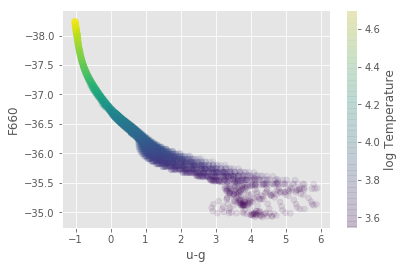

In [4]:
# Plotting one of the narrowbands to make sure it's all loaded in right.

plt.scatter(model_atm_mags['u']-model_atm_mags['r'],model_atm_mags['F660'],
            c=np.log10(model_atm_mags['Teff']), alpha=.1)
cb = plt.colorbar()
cb.set_label('log Temperature')
plt.gca().invert_yaxis()
plt.xlabel('u-g')
plt.ylabel('F660');

### Making color array:

In [5]:
filterlist = ['u', 'g', 'r', 'i', 'z', 'y']

color_list = []

# It seems like maybe this process shouldn't be necessary to go through again, but it ended up
# being what I had to do to get the array in a form that the KD tree function was happy with.
# Oh and of course at the moment it's actually still a magnitude array. I'll get to the filter-
# subtracting later.

for star in model_atm_mags:
    
    mags = []
    
    for filt in filterlist:

        mags.append(star[filt])
    color_list.append(mags)
    
print(color_list[0:2])

[[-40.059989441772672, -40.703819314921134, -40.45109888362424, -40.219424677455848, -40.111265919076899, -39.980302535214307], [-40.018023938221617, -40.728301864506548, -40.453883712874443, -40.213569858701405, -40.103366774223659, -39.984702913368565]]


# Now to make the KDTree(s):

In [6]:
from sklearn.neighbors import KDTree

In [7]:
color_array = np.array(color_list)
color_array.shape

(3808, 6)

In [8]:
trizzle = KDTree(color_array, leaf_size=40)

In [9]:
# Just copying the sklearn KDTree documentation examples in following cells:

dist, ind = trizzle.query(color_array[0:100], k=5)

In [10]:
print(ind[0:20])

[[   0 1911 3801 1435 1912]
 [   1 1913 1912 1437 3802]
 [   2 1914 1438 3802 1913]
 [   3 1915 3803 3804 1439]
 [   4 3804 3805 1916    5]
 [   5 3805 3806    6  480]
 [   6 3806 3807    5  481]
 [   7 1918 1442 3332 1443]
 [   8 1919 1444 1443 3333]
 [   9 1920 1445 1921 2857]
 [  10 1922 1446 1921 3335]
 [  11 1923 3336 1922 1447]
 [  12 3337   13 1924 3336]
 [  13 3338   12 3337  488]
 [  14 1449 1925  973 2863]
 [  15 1450 1926  975 1451]
 [  16 1927 1451 2864  976]
 [  17 1928 2865 1453 1452]
 [  18 1929 1930 1454 2866]
 [  19 1931 3344 1930 2867]]


In [11]:
print(dist[0:20])

[[ 0.          0.0174181   0.03033733  0.03127883  0.03162046]
 [ 0.          0.01929252  0.02169137  0.02188585  0.03011367]
 [ 0.          0.01685306  0.02307407  0.02326162  0.02705636]
 [ 0.          0.01912598  0.02224832  0.0264835   0.02946121]
 [ 0.          0.02173267  0.02379044  0.02715122  0.03247238]
 [ 0.          0.02183906  0.02289114  0.0252068   0.03232495]
 [ 0.          0.02469609  0.02516952  0.0252068   0.03460164]
 [ 0.          0.01642291  0.0176765   0.03294275  0.03571399]
 [ 0.          0.01421315  0.02100322  0.02213731  0.02963205]
 [ 0.          0.01469109  0.01686055  0.02340079  0.02696419]
 [ 0.          0.01771218  0.01918779  0.01935869  0.02459534]
 [ 0.          0.01816823  0.0224151   0.02603741  0.0267996 ]
 [ 0.          0.02199169  0.02657984  0.02912251  0.03067374]
 [ 0.          0.02496792  0.02657984  0.03012679  0.03308597]
 [ 0.          0.01073304  0.0263174   0.02991036  0.03635195]
 [ 0.          0.01197449  0.02164025  0.02355595  0.03

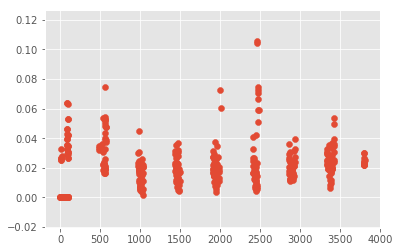

In [12]:
# I think this plot is probably messed up, but whatever.

plt.scatter(ind, dist);

### So now I could use some guidance on where to go next.

In [13]:
# OK, so next up, I think we'll want to package this up as a callable class so that 
# given observed colors and uncertainties, we return closest Teff, metallicity, logg and uncertainties.

# For example, let's say we have star 500
observed = color_array[500,:]

In [14]:
# this should return 500, since it's looking up something in the tree
dist, ind = trizzle.query(observed.reshape(1,-1), k=1)
ind

array([[500]])

In [15]:
# Now, what happens if we add some Gaussian noise to it 100 different ways. 
# I'm pretending that there's 0.05 mag error on the observation of each magnitude
observed = color_array[500,:] + np.random.randn(600).reshape(100, 6)*.05

In [16]:
dist, ind = trizzle.query(observed, k=1)

10500.0 10605.0 10750.0


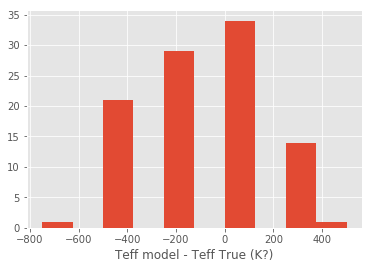

In [17]:
plt.hist(model_atm_mags['Teff'][ind]-model_atm_mags['Teff'][500])
plt.xlabel('Teff model - Teff True (K?)')
print(np.median(model_atm_mags['Teff'][ind]), np.mean(model_atm_mags['Teff'][ind]), model_atm_mags['Teff'][500])

-0.5 -0.701 -1.0


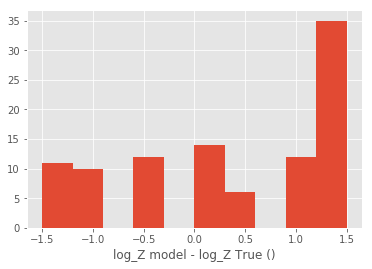

In [18]:
plt.hist(model_atm_mags['log_Z'][ind]-model_atm_mags['log_Z'][500])
plt.xlabel('log_Z model - log_Z True ()')
print(np.median(model_atm_mags['log_Z'][ind]), np.mean(model_atm_mags['log_Z'][ind]), model_atm_mags['log_Z'][500])
# I don't understand why this isn't peaked at 0. Hopefully going to colors rather than straight mags will fix that.
# Yeah that's weird.

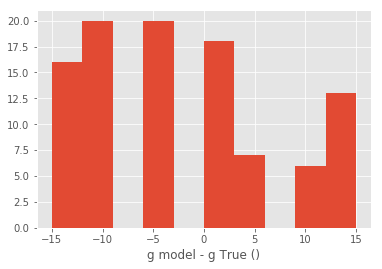

In [19]:
plt.hist(model_atm_mags['gravity'][ind]-model_atm_mags['gravity'][500])
plt.xlabel('g model - g True ()');

# Object-making stuff:

In [20]:
class stellar_param_fitter(object):
    
    '''Makes a kd-tree based on stellar models for the purposes of identifying the properties of
    input star(s).'''
    
    def __init__(self, colors=['g-r','r-i']):
        # colors must be a list of 'band1-band2'
        
        # Read in the saved array and construct the kdtree with the given colors
        temp = np.load('model_atm_mags.npz')
        # Have to copy to get it into memory, otherwise it reads off disk every time
        self.model_atm_cols = []
        self.model_atm_magstest = temp['model_atm_mags'].copy()
        for colorStr in colors:
            band1,band2=colorStr.split("-")
            color = self.model_atm_magstest[band1] - self.model_atm_magstest[band2]
            self.model_atm_cols.append(color)
        temp.close()
        # Construct kdtree
        self.model_atm_cols = np.array(self.model_atm_cols).T
        self.kdtree = KDTree(self.model_atm_cols)
        
    def __call__(self, input_colors):
        
        # Input colors could be a single measurement, or an array with 
        # Querry the kd-tree.
        dist, ind = self.kdtree.query(input_colors, k=1)
        # Construct an array to hold the results
        keys = ['Teff', 'gravity', 'log_Z']
        output = {}
        for key in keys:
            output[key] = self.model_atm_magstest[key][ind]
        return output

In [21]:
thing = stellar_param_fitter()

In [22]:
star500 = np.array(
    [[model_atm_mags['g'][500]-model_atm_mags['r'][500]], [model_atm_mags['r'][500]-model_atm_mags['i'][500]]])
star500 = star500.reshape(1,-1)
star500.shape

(1, 2)

In [23]:
print(
    thing(star500), 
    model_atm_mags['Teff'][500],
    model_atm_mags['gravity'][500], 
    model_atm_mags['log_Z'][500])

{'Teff': array([[ 10750.]]), 'gravity': array([[ 35.]]), 'log_Z': array([[-1.]])} 10750.0 35.0 -1.0


## Moving in the simulated data:

In [24]:
temp = np.load('stars_from_catsim.npz')
# Have to copy to get it into memory, otherwise it reads off disk every time - good to know!
sim_data = temp['from_catsim'].copy()
temp.close()

In [25]:
sim_data[0:2]

array([( 3500., -1.,  4.5,  29.15061,  27.86252,  26.88286),
       ( 2700., -0.,  2. ,  27.6896 ,  26.25251,  24.4602 )],
      dtype=[('teff', '<f8'), ('metallicity', '<f8'), ('logg', '<f8'), ('gmag', '<f8'), ('rmag', '<f8'), ('imag', '<f8')])

In [26]:
# simulated color array:

col1 = []
col2 = []
sim_color_list = []

for star in sim_data:
    
    c1 = star['gmag']-star['rmag']
    c2 = star['rmag']-star['imag']
    colors = [c1, c2]
    col1.append(c1)
    col2.append(c2)
    sim_color_list.append(colors)

print(sim_color_list[0:2])

[[1.2880900000000004, 0.97965999999999909], [1.4370899999999978, 1.7923100000000005]]


In [27]:
sim_color_array = np.array(sim_color_list)
sim_color_array.shape

(127426, 2)

In [28]:
# Copying the color kd tree stuff out of the object so it works when we call "ind" to test how well the model works.
colors=['g-r','r-i']
temp = np.load('model_atm_mags.npz')
        # Have to copy to get it into memory, otherwise it reads off disk every time
model_atm_cols = []
model_atm_magstest = temp['model_atm_mags'].copy()
for colorStr in colors:
    band1,band2=colorStr.split("-")
    color = model_atm_magstest[band1] - model_atm_magstest[band2]
    model_atm_cols.append(color)
temp.close()

model_atm_cols = np.array(model_atm_cols).T
kdtree = KDTree(model_atm_cols)

dist, ind = kdtree.query(sim_color_array, k=1)

In [29]:
thing(sim_color_array) # Holy shit it compiled...

{'Teff': array([[ 3500.],
        [ 3500.],
        [ 3500.],
        ..., 
        [ 8000.],
        [ 8250.],
        [ 8000.]]), 'gravity': array([[ 20.],
        [ 10.],
        [ 10.],
        ..., 
        [ 30.],
        [ 40.],
        [ 40.]]), 'log_Z': array([[-0.5],
        [ 0.5],
        [ 0. ],
        ..., 
        [ 0.5],
        [ 0.2],
        [ 0.2]])}

In [30]:
model_atm_mags['Teff'][ind[0]],sim_data['teff'][0]

(array([ 3500.]), 3500.0)

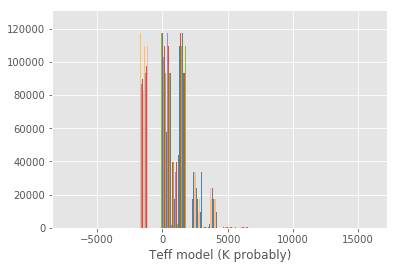

In [44]:
# trying some plots:

plt.hist(model_atm_mags['Teff'][ind]-sim_data['teff'][0:1000])
plt.xlabel('Teff model (K probably)');

### Much better!

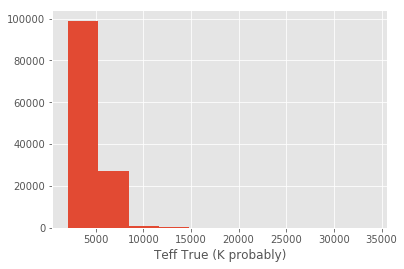

In [32]:
plt.hist(sim_data['teff'])
plt.xlabel('Teff True (K probably)');

In [33]:
# doing a little more analysis on predicted vs actual temp:

predicted_temps = model_atm_mags['Teff'][ind]
actual_temps = [sim_data['teff']]

In [34]:
# one would hope for the median temps to be identical, right?

print(np.median(predicted_temps), np.mean(predicted_temps),
      np.median(actual_temps), np.mean(actual_temps))

3500.0 4119.04948755 3600.0 4131.33881625


In [35]:
# Trying metallicity and gravity:

predicted_Z = [model_atm_mags['log_Z'][ind]]
actual_Z = [sim_data['metallicity']]

In [36]:
print(np.median(predicted_Z), np.mean(predicted_Z),
      np.median(actual_Z), np.mean(actual_Z)) # - what?

0.0 -0.638911995982 -1.0 -43.3705876352


In [37]:
predicted_g = [model_atm_mags['gravity'][ind]]
actual_g = [sim_data['logg']]

In [38]:
print(np.median(predicted_g), np.mean(predicted_g),
      np.median(actual_g), np.mean(actual_g))

15.0 19.8008255772 4.0 3.21132657385


In [39]:
# maybe adding in the other colors will fix this?

# Visualizing data:

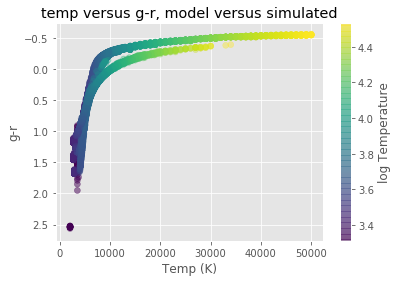

In [40]:
# maybe matches up better with colors:

plt.scatter(model_atm_mags['Teff'], model_atm_mags['g']-model_atm_mags['r'],
            c=np.log10(model_atm_mags['Teff']), alpha=.5)
plt.scatter(sim_data['teff'], sim_data['gmag']-sim_data['rmag'],
            c=np.log10(sim_data['teff']), alpha=.4)
cb = plt.colorbar()
cb.set_label('log Temperature')
plt.gca().invert_yaxis()
plt.xlabel('Temp (K)')
plt.ylabel('g-r')
plt.title('temp versus g-r, model versus simulated');

# yes that is much better

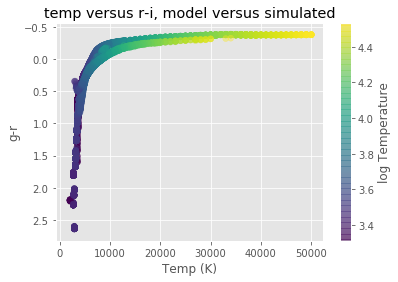

In [41]:
plt.scatter(model_atm_mags['Teff'], model_atm_mags['r']-model_atm_mags['i'],
            c=np.log10(model_atm_mags['Teff']), alpha=.5)
plt.scatter(sim_data['teff'], sim_data['rmag']-sim_data['imag'],
            c=np.log10(sim_data['teff']), alpha=.4)
cb = plt.colorbar()
cb.set_label('log Temperature')
plt.gca().invert_yaxis()
plt.xlabel('Temp (K)')
plt.ylabel('g-r')
plt.title('temp versus r-i, model versus simulated');

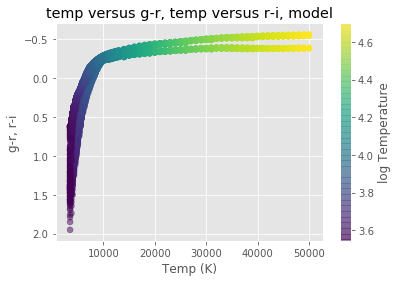

In [42]:
plt.scatter(model_atm_mags['Teff'], model_atm_mags['g']-model_atm_mags['r'],
            c=np.log10(model_atm_mags['Teff']), alpha=.5)
plt.scatter(model_atm_mags['Teff'], model_atm_mags['r']-model_atm_mags['i'],
            c=np.log10(model_atm_mags['Teff']), alpha=.4)
cb = plt.colorbar()
cb.set_label('log Temperature')
plt.gca().invert_yaxis()
plt.xlabel('Temp (K)')
plt.ylabel('g-r, r-i')
plt.title('temp versus g-r, temp versus r-i, model');

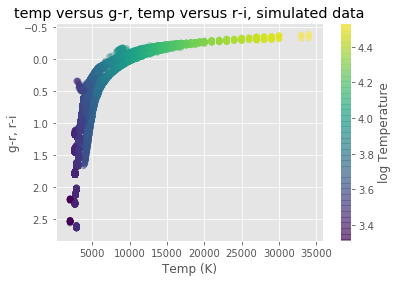

In [43]:
plt.scatter(sim_data['teff'], sim_data['gmag']-sim_data['rmag'],
            c=np.log10(sim_data['teff']), alpha=.5)
plt.scatter(sim_data['teff'], sim_data['rmag']-sim_data['imag'],
            c=np.log10(sim_data['teff']), alpha=.4)
cb = plt.colorbar()
cb.set_label('log Temperature')
plt.gca().invert_yaxis()
plt.xlabel('Temp (K)')
plt.ylabel('g-r, r-i')
plt.title('temp versus g-r, temp versus r-i, simulated data');